# Inflação IPCA — Brasil (BACEN/SGS 433)

Gerado em 2025-10-26.

Variação mensal do IPCA (%, mensal) — índice oficial de inflação ao consumidor (IBGE), via SGS 433.

# **1. Importar as bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [6]:
!pip install pmdarima

In [7]:
!pip uninstall -y numpy pmdarima scikit-learn Cython
!pip install numpy==1.26.4 scikit-learn==1.3.2 Cython==3.0.10 pmdarima==2.0.4 --no-cache-dir

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: Cython 3.0.10
Uninstalling Cython-3.0.10:
  Successfully uninstalled Cython-3.0.10
'import warnings' failed; traceback:
Traceback (most recent call last):
  File "/usr/lib/python3.12/warnings.py", line 587, in <module>
  File "/usr/lib/python3.12/warnings.py", line 211, in _processoptions
    _setoption(arg)
  File "/usr/lib/python3.12/warnings.py", line 227, in _setoption
    import re
  File "/usr/lib/python3.12/re/__init__.py", line 142, in <module>
    @enum._simple_enum(enum.IntFlag, boundary=enum.KEEP)
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/enum.py", line 1746, 

In [2]:
import pmdarima as pm

# **2. Pré-Processamento dos dados**

## **2.1 - Input dos dados**

In [4]:
df = pd.read_csv('/content/03_Inflacao_BR.csv')
df.head()

,date,value
0,1980-02-01,462.0
1,1980-03-01,604.0
2,1980-04-01,529.0
3,1980-05-01,570.0
4,1980-06-01,531.0


## **2.2 - Indexamento da coluna "date"**

In [5]:
# Converter a coluna 'date' para o formato datetime
df['date'] = pd.to_datetime(df['date'])

# Definir a coluna 'date' como o índice do DataFrame
df.set_index('date', inplace=True)

print("--- Informações do DataFrame Pós-Processamento ---")
df.info()
print("\n--- Head do DataFrame com DatetimeIndex ---")
print(df.head())

--- Informações do DataFrame Pós-Processamento ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 1980-02-01 to 2025-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   548 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB

--- Head do DataFrame com DatetimeIndex ---
            value
date             
1980-02-01  462.0
1980-03-01  604.0
1980-04-01  529.0
1980-05-01  570.0
1980-06-01  531.0


## **2.3 - Visualização da serie temporal**

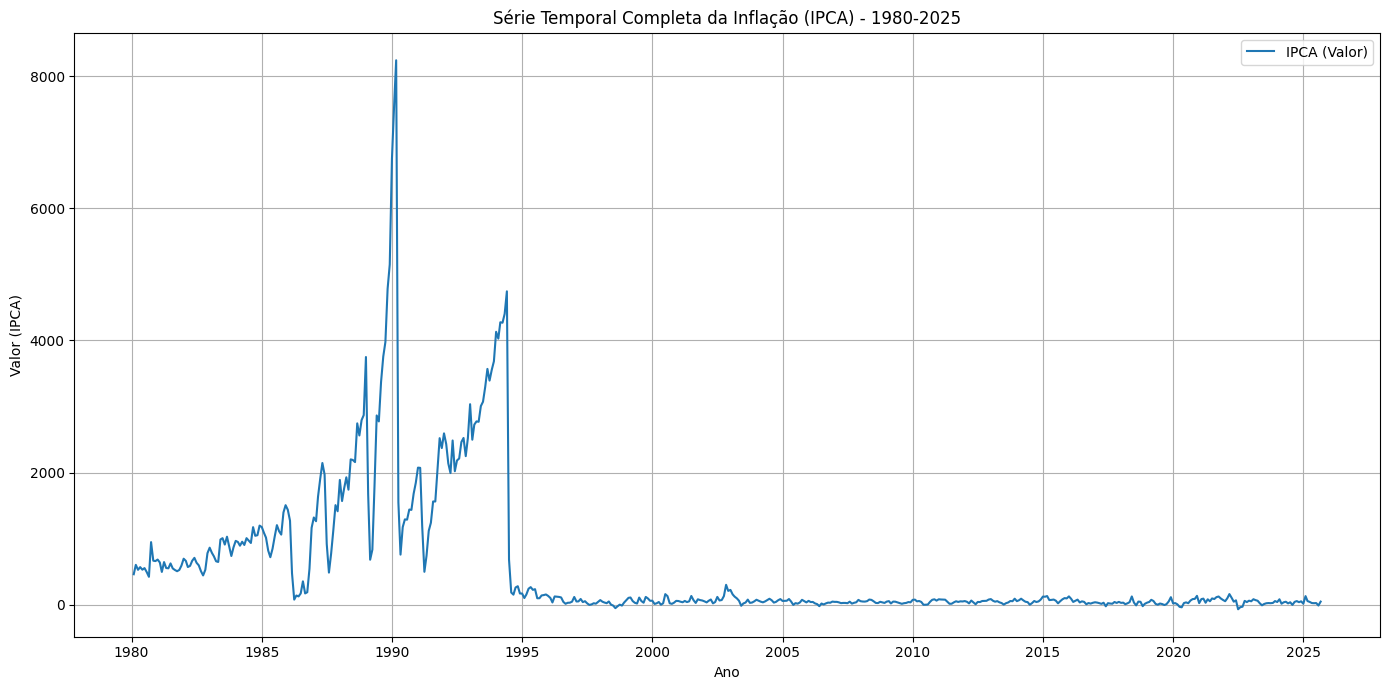

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['value'], label='IPCA (Valor)')
plt.title('Série Temporal Completa da Inflação (IPCA) - 1980-2025')
plt.xlabel('Ano')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### **Análise da Visualização (1980-2025):**
A série é dominada por valores absurdamente altos no período pré-1994 (hiperinflação). Os valores pós-1994 são tão pequenos em comparação que a linha do gráfico parece estar "achatada" no eixo zero.

O processo que gerava a inflação em 1988 (centenas ou milhares por cento ao mês) não tem nenhuma relação com o processo que gera a inflação em 2024 (dígitos únicos ao ano).


### **Metodológica:**
Seria incorreto tentar usar a série inteira. Poderíamos tentar aplicar transformações (ex: log) e múltiplas diferenciações (d=2 ou d=3 no ARIMA) para "forçar" a estacionariedade. No entanto, o modelo resultante estaria tentando aprender com padrões que não existem mais. Além disso, a premissa de homocedasticidade (variância constante) é violada de forma extrema.


Por isso, **optamos por "Fatiar" a serie**. Vamos usar apenas o período em que o regime econômico é estável e relevante para o futuro. O Plano Real foi implementado em julho de 1994. Para garantir que pegamos um período onde a nova moeda já estava estabilizada, vamos definir nossa data de início em 1º de Janeiro de 1995.


Nosso objetivo de prever os próximos 12 meses (2025-2026) deve ser baseado no comportamento da inflação da era moderna (1995-2025).

## **2.4 - Fatiamento do dataframe**

In [7]:
start_date = '1995-01-01'
df_pos_real = df.loc[start_date:].copy()

print(f"--- Análise do Período Pós-Plano Real ---")
print(f"Dados selecionados a partir de: {start_date}")
print(f"Número de observações original: {len(df)}")
print(f"Número de observações no novo DataFrame: {len(df_pos_real)}")

--- Análise do Período Pós-Plano Real ---
Dados selecionados a partir de: 1995-01-01
Número de observações original: 548
Número de observações no novo DataFrame: 369


## **2.5 - Visualização da serie após o fatiamento**

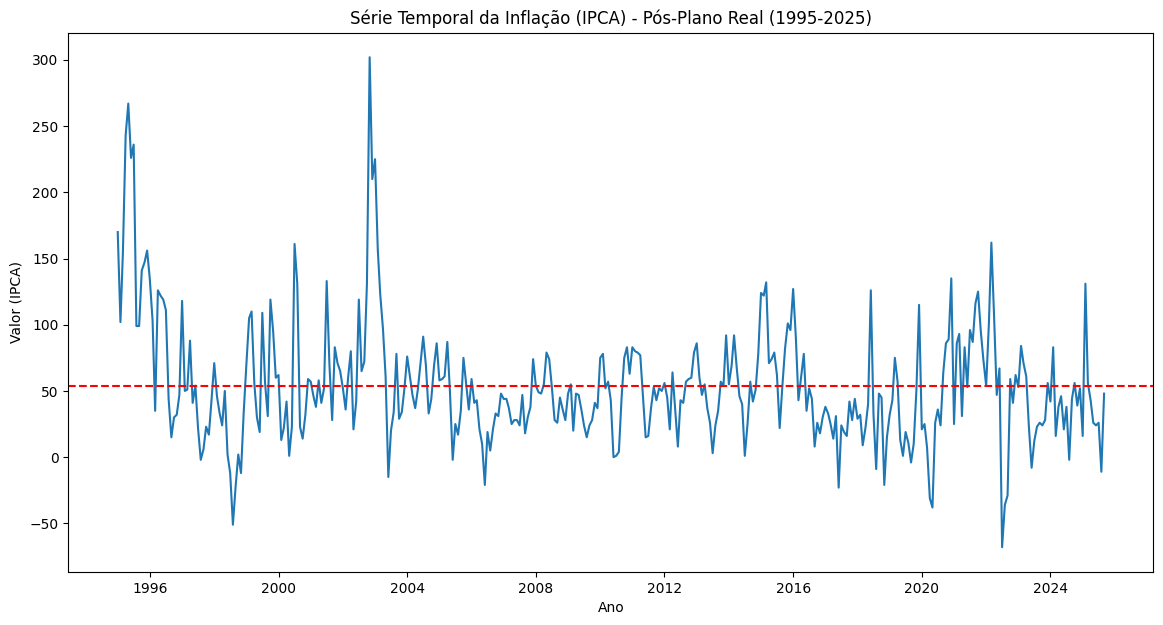

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(df_pos_real.index, df_pos_real['value'], label='IPCA (Pós-Real)')
plt.title('Série Temporal da Inflação (IPCA) - Pós-Plano Real (1995-2025)')
plt.xlabel('Ano')
plt.ylabel('Valor (IPCA)')

# Adicionar uma linha da média para referência
mean_value = df_pos_real['value'].mean()
plt.axhline(mean_value, color='red', linestyle='--', label=f'Média ({mean_value:.2f})')

-- **Não-Estacionariedade (Média)**: A série é **claramente não-estacionária** na média. Ela flutua em longos períodos acima ou abaixo (ex: o pico de 2003, o pico de 2015, o pico de 2021). Ela exibe o que parece ser um **"passeio aleatório"** (random walk), o que sugere que precisaremos de diferenciação (o "I" do ARIMA).

-- **Não-Estacionariedade (Variância)**: A série também parece heteroscedástica (não-estacionária na variância). A volatilidade é visivelmente maior no início do período (1995-2003) do que no período 2005-2019. Isso pode ser um desafio para modelos lineares como o ARIMA.

-- **Sazonalidade:** É difícil afirmar visualmente se há sazonalidade. Pode haver, mas ela está "escondida" pela tendência e pela volatilidade.


## **2.6 - Divisão de treino e teste**

Antes de qualquer análise (ADF, ACF, decomposição), iremos separar os dados. Vamos reservar os últimos 12 meses como nosso conjunto de teste. Toda a nossa análise e treinamento de modelos será feita apenas no conjunto de treino.

In [9]:
n_test = 12
train_data = df_pos_real.iloc[:-n_test]
test_data = df_pos_real.iloc[-n_test:]

print(f"--- Divisão dos Dados ---")
print(f"Total de observações (Pós-Real): {len(df_pos_real)}")
print(f"Dados de Treino: {len(train_data)} (de {train_data.index.min().date()} até {train_data.index.max().date()})")
print(f"Dados de Teste: {len(test_data)} (de {test_data.index.min().date()} até {test_data.index.max().date()})")

--- Divisão dos Dados ---
Total de observações (Pós-Real): 369
Dados de Treino: 357 (de 1995-01-01 até 2024-09-01)
Dados de Teste: 12 (de 2024-10-01 até 2025-09-01)


## **2.7 - Teste de Estacionariedade (ADF)**

A hipótese nula (H0) do ADF é que a série possui uma raiz unitária (é não-estacionária). Se o p-valor for alto (ex: > 0.05), falhamos em rejeitar a H0, e confirmamos que a série precisa de diferenciação.

In [10]:
print("--- Teste Dickey-Fuller Aumentado (ADF) na Série Original (Treino) ---")
adf_result = adfuller(train_data['value'].dropna())
adf_pvalue = adf_result[1]
adf_stat = adf_result[0]

print(f'Estatística ADF: {adf_stat:.4f}')
print(f'p-valor: {adf_pvalue:.4f}')

if adf_pvalue > 0.05:
    print("Resultado: Falhamos em rejeitar H0. A série é NÃO-ESTACIONÁRIA.")
else:
    print("Resultado: Rejeitamos H0. A série é ESTACIONÁRIA.")

--- Teste Dickey-Fuller Aumentado (ADF) na Série Original (Treino) ---
Estatística ADF: -5.0214
p-valor: 0.0000
Resultado: Rejeitamos H0. A série é ESTACIONÁRIA.


- Teste ADF: (p-valor < 0.05, imagino) disse: "A série é Estacionária".
- A Análise Visual mostrou uma série que "passeia" e não parece reverter a uma média fixa. Ela parece Não-Estacionária.
- O Teste ADF é um teste estatístico para raiz unitária. Em um período muito longo (1995-2024), é possível que a série tenha revertido à média o suficiente para "passar" no teste.
- MAS Para modelagem, a análise visual e, mais importante, a Análise de Autocorrelação (ACF), são mais importantes que o Teste ADF isolado.

## **2.8 - Decomposição da Série Temporal e Análise de Autocorrelação (ACF e PACF)**

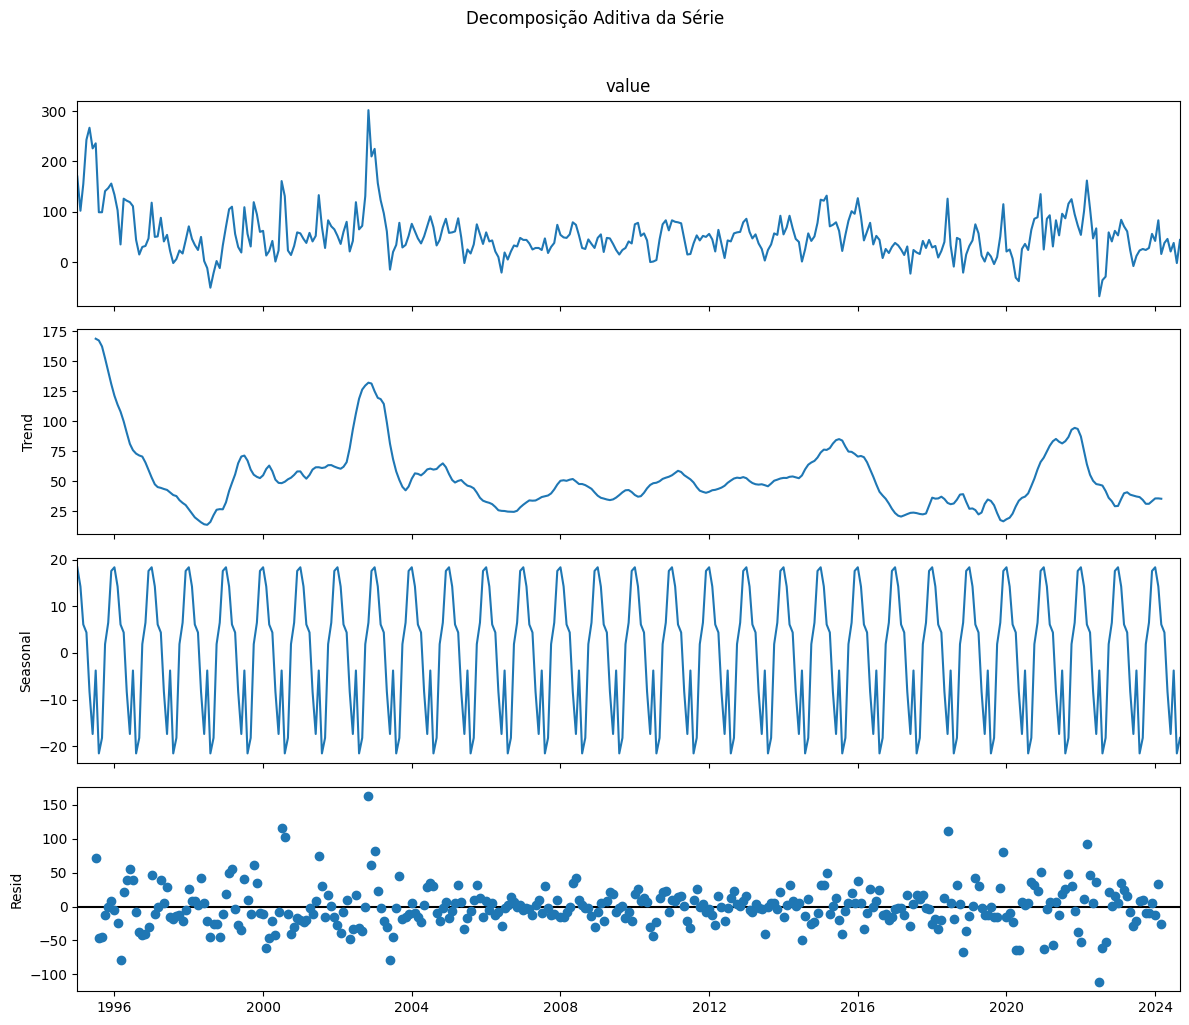

In [11]:
decomposition = seasonal_decompose(train_data['value'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.suptitle('Decomposição Aditiva da Série', y=1.02)
plt.tight_layout()

**Análise da Decomposição Aditiva**
- **Tendência:** A tendência não é uma linha reta; ela sobe, desce e sobe de novo. Isso é um forte indício de não-estacionariedade na média. A inflação não tem um "ponto central" fixo, ela "passeia" (random walk).

- **Sazonalidade (Seasonal):** Existe um padrão que se repete todo ano. Ele é pequeno comparado à tendência, mas é consistente.

- **Resíduo (Residual):** Notamos que ele é mais "grosso" (volátil) no início (pré-2005) e no final (pós-2021). Isso confirma a heteroscedasticidade (variância não-constante).



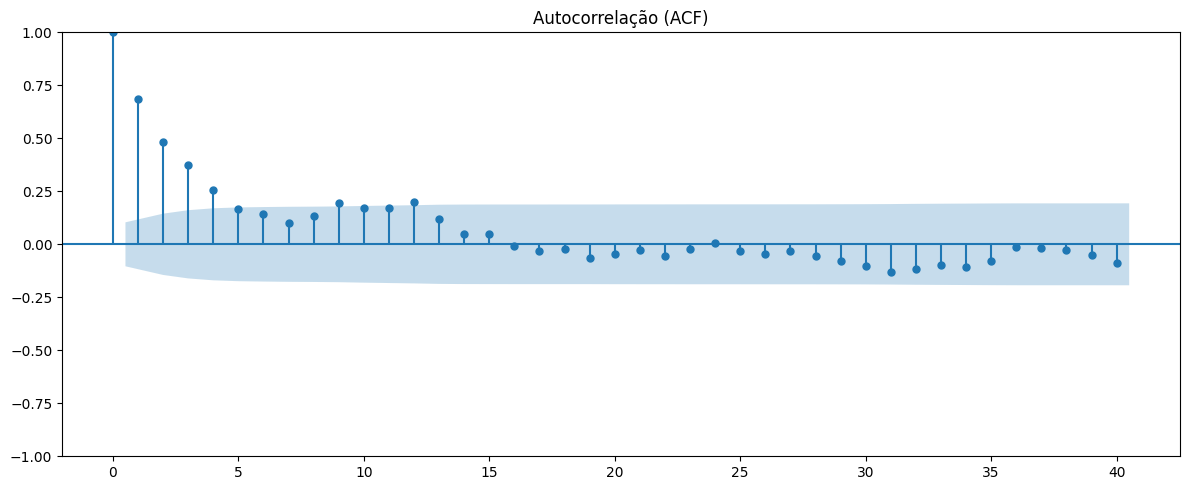

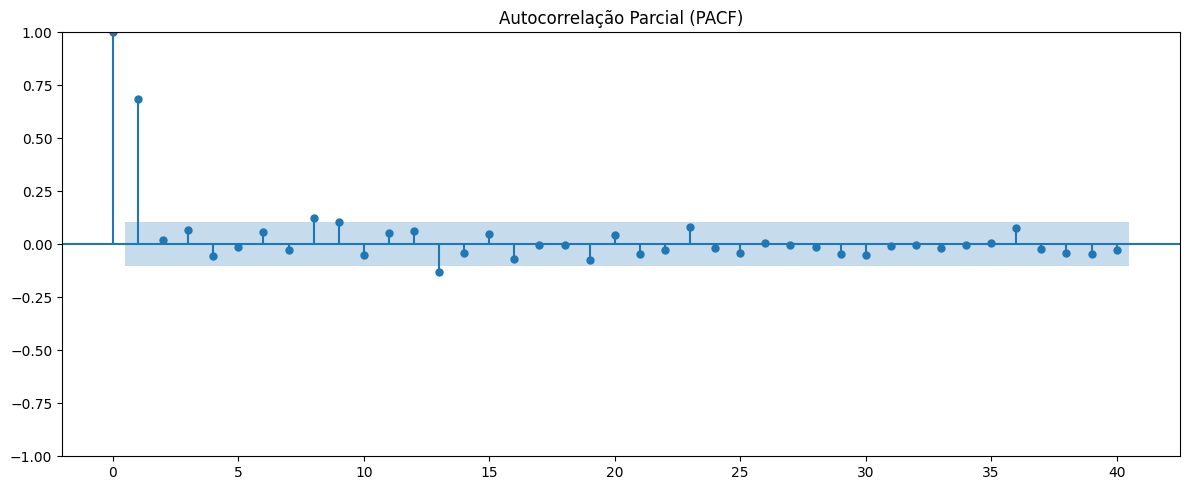

In [12]:
n_lags = 40

# ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train_data['value'].dropna(), lags=n_lags, ax=ax, title='Autocorrelação (ACF)')
plt.tight_layout()

# PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train_data['value'].dropna(), lags=n_lags, ax=ax, title='Autocorrelação Parcial (PACF)')
plt.tight_layout()

**Observação:** As barras do ACF decaem muito lentamente. Elas continuam significantes (fora da área azul) por muitos lags (15+).

**Interpretação:** Este é o sintoma clássico de não-estacionariedade. Uma série estacionária "esquece" seu passado rapidamente (o ACF cairia para zero após 2 ou 3 lags). Esta série tem uma memória longa (o valor de hoje é muito parecido com o de 6, 12, 18 meses atrás). A série precisa de diferenciação não-sazonal. Vamos definir d=1.

# **3. Tornando a serie estacionaria**

Nosso objetivo é transformar a série de "Treino" em "ruído branco" (estacionária).

Já identificamos:
- d=1 (Diferenciação Não-Sazonal) para remover a Tendência.
- M=12 (Período Sazonal).
- Como também vimos sazonalidade clara, é quase certo que também precisaremos de Diferenciação Sazonal (D=1).


Nosso próximo passo é aplicar essas duas diferenciações (d=1 e D=1) e, então, olhar novamente para os gráficos ACF e PACF. Os gráficos ACF/PACF que acabamos de ver serviram para identificar o d. Agora, precisamos de novos gráficos (na série já diferenciada) para identificar os parâmetros p, q (não-sazonais) e P, Q (sazonais).

In [13]:
# Aplicamos a diferenciação não-sazonal (d=1)
train_data_diff = train_data['value'].diff(1)

# Aplicamos a diferenciação sazonal (D=1, M=12) na série já diferenciada
train_data_diff_seasonal = train_data_diff.diff(12).dropna()

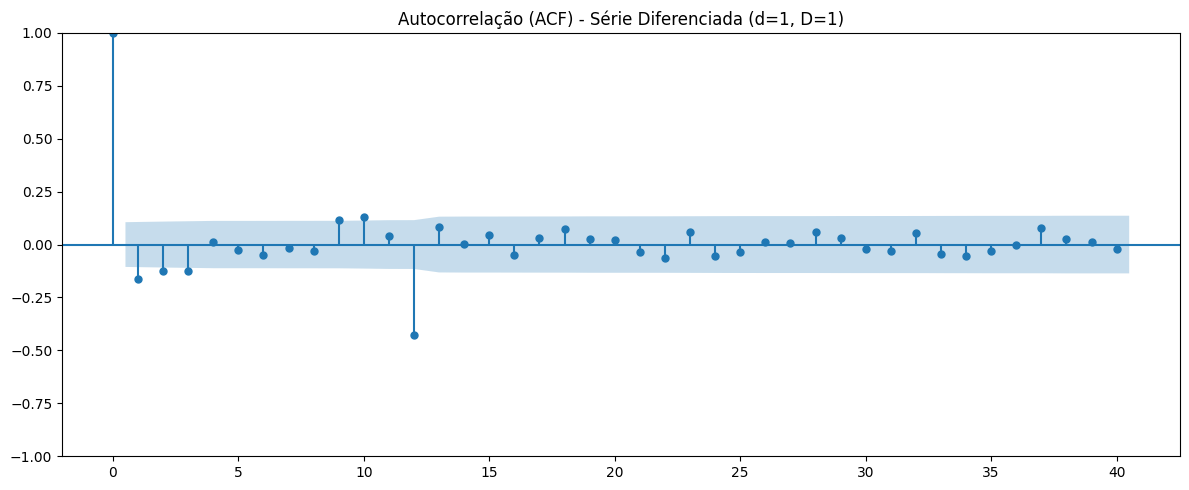

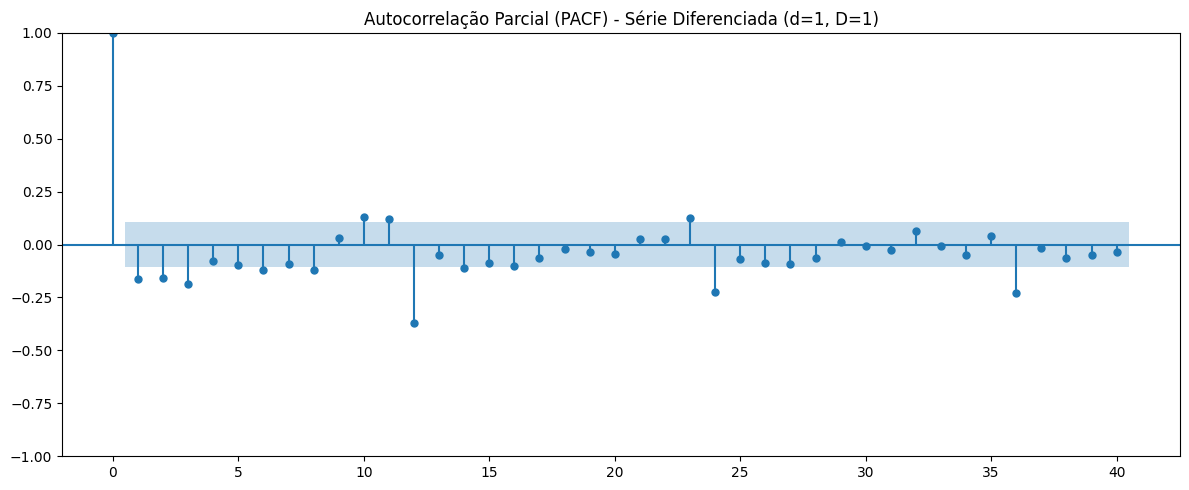

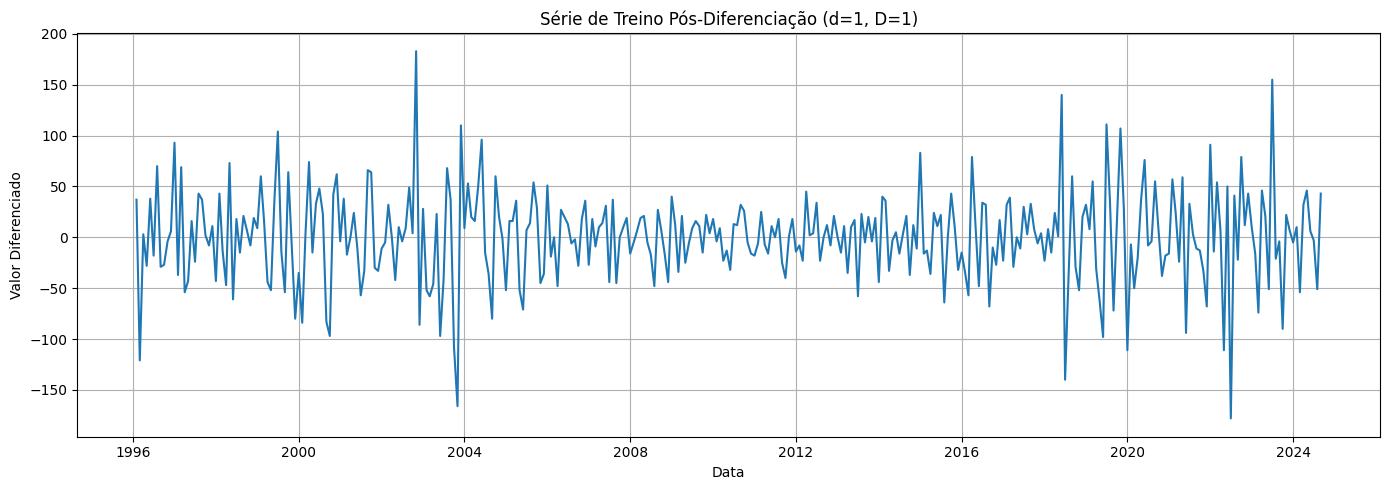

In [14]:
n_lags = 40

# Gráfico ACF (Pós-diferenciação)
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train_data_diff_seasonal, lags=n_lags, ax=ax, title='Autocorrelação (ACF) - Série Diferenciada (d=1, D=1)')
plt.tight_layout()

# Gráfico PACF (Pós-diferenciação)
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train_data_diff_seasonal, lags=n_lags, ax=ax, title='Autocorrelação Parcial (PACF) - Série Diferenciada (d=1, D=1)')
plt.tight_layout()


# série diferenciada
plt.figure(figsize=(14, 5))
plt.plot(train_data_diff_seasonal)
plt.title('Série de Treino Pós-Diferenciação (d=1, D=1)')
plt.xlabel('Data')
plt.ylabel('Valor Diferenciado')
plt.grid(True)
plt.tight_layout()

Análise dos Gráficos Pós-Diferenciação

**Visualização da Série Diferenciada**
- A série flutua em torno do zero, sem nenhuma tendência óbvia e sem os padrões sazonais claros que víamos antes.
- Confirmamos que os parâmetros d=1 (para remover a tendência) e D=1 (para remover a sazonalidade, com m=12) são apropriados.

**Análise do ACF e PACF Diferenciados**
- No ACF: Vemos um "spike" (pico) negativo muito forte no lag 12, que corta para zero depois (o lag 24 não é significativo). Isso sugere Q=1.

- No PACF: Vemos um "spike" negativo muito forte no lag 12, que corta para zero depois. Isso sugere P=1.

Não-Sazonal (Lags 1, 2, 3...)
- No ACF: Vemos spikes significativos nos lags 1, 2, 3 e 4. Sugere q=4.
- No PACF: Vemos spikes significativos nos lags 1, 2, 3 e 4. Sugere p=4.

⚠️ Análise Crítica
Se fôssemos seguir estritamente a análise visual, poderíamos propor um modelo incrivelmente complexo, como SARIMA(p=4, d=1, q=4) x (P=1, D=1, Q=1, 12).


Por que isso é um problema (para o trabalho)?
- Subjetividade: A leitura do ACF/PACF não é uma ciência exata. Outra pessoa poderia dizer p=3 ou q=2.

- Overfitting (Sobreajuste): Um modelo com tantos parâmetros (4+1+4+1+1 = 11 parâmetros) é quase garantido de se sobreajustar aos dados de treino.

- Comportamento Misto (ARMA): Quando ambos os gráficos (ACF e PACF) têm vários picos (em vez de um "cortar" e o outro "decair"), isso indica um comportamento misto (ARMA), que é o mais difícil de identificar manualmente.




# **4. Modelagem: SARIMA**

In [15]:
# Vamos forçar os parâmetros que já identificamos (d, D, m)
# d=1 (não-sazonal)
# D=1 (sazonal)
# m=12 (período sazonal)
# stepwise=True: Faz uma busca mais rápida (inteligente)
# trace=True: Mostra todos os modelos que está testando
# suppress_warnings=True: Oculta avisos de convergência
# information_criterion='aic': Usar o AIC para ranquear

auto_model = pm.auto_arima(
    train_data['value'],
    start_p=0, start_q=0,
    max_p=4, max_q=4,
    m=12,
    d=1,
    D=1,
    seasonal=True,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    information_criterion='aic'
)

print("\n--- Resultado da Busca (Auto-ARIMA) ---")
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3601.011, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3522.417, Time=0.94 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3438.532, Time=1.72 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3588.097, Time=0.73 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3439.742, Time=4.93 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3439.649, Time=3.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3517.619, Time=0.80 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3441.307, Time=7.57 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3451.259, Time=0.70 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3405.760, Time=2.42 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3406.703, Time=5.07 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3406.564, Time=9.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(1,1,1)(1,1,2)[12]     

**SARIMAX:** É um SARIMA (Sazonal AR I MA) com o X significando que ele pode lidar com "variáveis eXógenas"

**Ordem Não-Sazonal (p, d, q) = (1, 1, 1)**
- p=1 (AR): Um termo Autorregressivo. A inflação de hoje (diferenciada) é influenciada pela inflação do mês passado (diferenciada).
- d=1 (I): Uma Diferenciação. Exatamente como provamos manualmente. Isso removeu a tendência.
- q=1 (MA): Um termo de Média Móvel. A inflação de hoje é influenciada pelo erro da previsão do mês passado.

**Ordem Sazonal (P, D, Q, m) = (1, 1, 1, 12)**
- P=1 (AR Sazonal): Um termo Autorregressivo Sazonal. A inflação de hoje é influenciada pela inflação de 12 meses atrás.
- D=1 (I Sazonal): Uma Diferenciação Sazonal. Exatamente como provamos manualmente. Isso removeu o padrão anual.
- Q=1 (MA Sazonal): Um termo de Média Móvel Sazonal. A inflação de hoje é influenciada pelo erro da previsão de 12 meses atrás.
- m=12: O período sazonal é de 12 meses (anual).


Nossa análise visual (ACF/PACF) foi confirmada (d=1, D=1). O auto_arima refinou a seleção dos termos AR/MA para o modelo mais simples que melhor explica os dados, que é (1,1,1)x(1,1,1,12).

### **4.1 O modelo e valido?**

Um modelo de série temporal perfeito deve capturar toda a estrutura (tendência, sazonalidade, autocorrelação) dos dados. O que deve sobrar são apenas os resíduos (os erros de previsão dentro do treino), e esses resíduos devem se parecer com "ruído branco" (white noise).

Um resíduo "ruído branco" deve ter:
- Média zero (o modelo não erra consistentemente para cima ou para baixo).
- Variância constante (homocedasticidade).
- Não ter autocorrelação (o erro de hoje não pode prever o erro de amanhã).
- Ser normalmente distribuído (os erros são aleatórios).

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  357
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1619.522
Date:                            Mon, 17 Nov 2025   AIC                           3249.044
Time:                                    14:48:14   BIC                           3268.039
Sample:                                01-01-1995   HQIC                          3256.621
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6388      0.042     15.224      0.000       0.557       0.721
ma.L1         -1.0000     76.342   

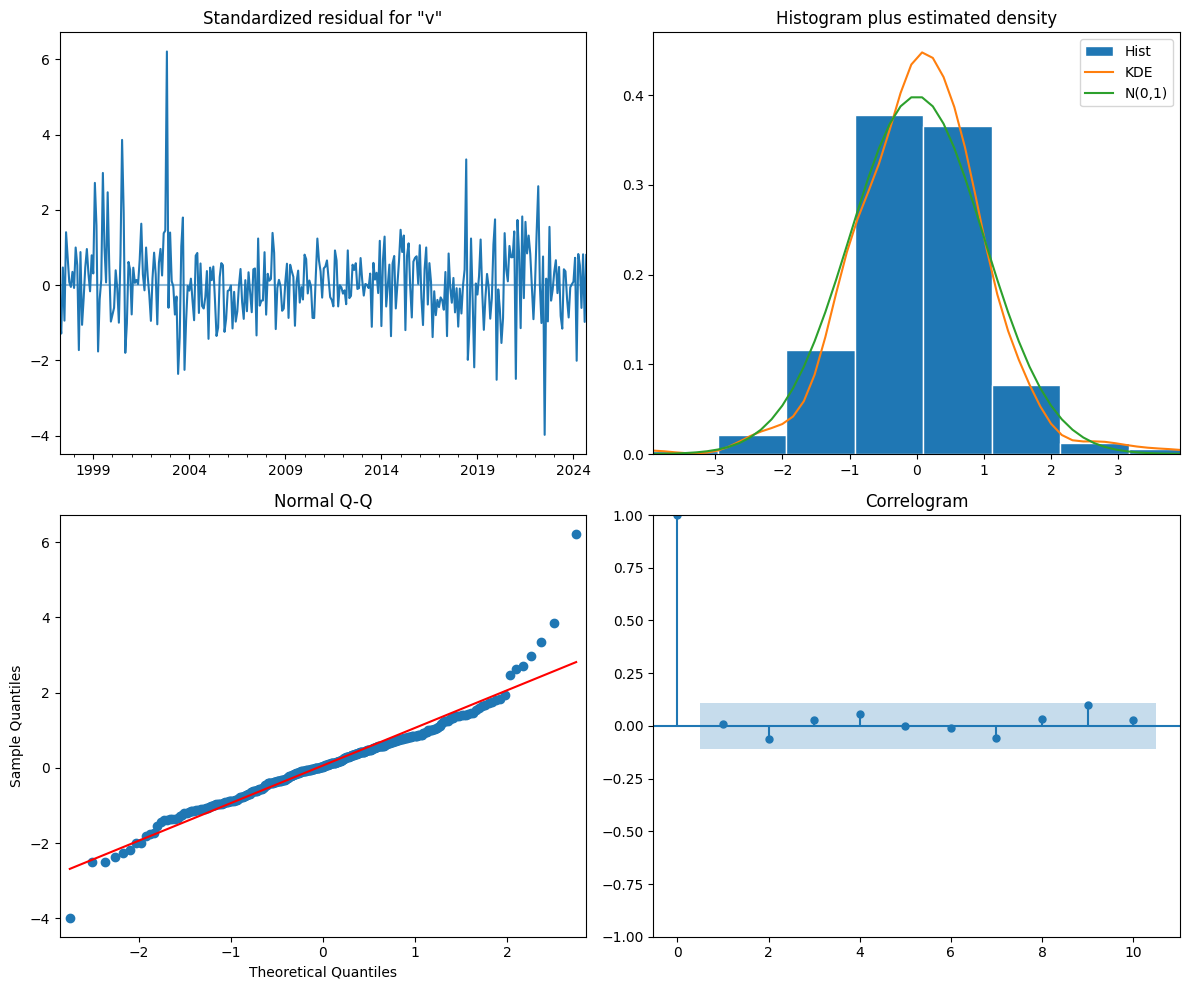

In [16]:
# Instanciar o modelo com os parâmetros que encontramos
best_order = (1, 1, 1) # (p, d, q)
best_seasonal_order = (1, 1, 1, 12) # (P, D, Q, m)

model = SARIMAX(
    train_data['value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Treinar (fit) o modelo
model_fit = model.fit(disp=False)
print(model_fit.summary())

# --- Diagnóstico dos Resíduos ---

# Esta função plota 4 gráficos essenciais:
# 1. Resíduos Padronizados (Standardized residual)
# 2. Histograma + KDE (Histogram plus estimated density)
# 3. Gráfico QQ (Normal Q-Q)
# 4. Correlograma (ACF dos resíduos)

fig = model_fit.plot_diagnostics(figsize=(12, 10))
plt.tight_layout()

**Análise Visual:** Este gráfico de 4 quadrantes avalia se os resíduos (os erros do modelo) se comportam como "ruído branco" (aleatório e sem padrões).

**1. Standardized residual (Resíduos Padronizados - Topo Esquerda):**
- Vemos que os erros não têm variância constante. Há "picos" de volatilidade (erros grandes) em 2002, 2015 e 2021-2022, e períodos de calma.
- Conclusão:  A série é heteroscedástica. O modelo SARIMA, por ser linear, não captura essa mudança na volatilidade.

**2. Histogram plus estimated density (Histograma - Topo Direita):**
- A linha verde (distribuição real dos erros) é mais "pontuda" (leptocúrtica) e tem "caudas mais pesadas" do que a linha laranja (distribuição normal perfeita).
- Conclusão: Os resíduos não são normalmente distribuídos. Isso significa que "choques" (erros extremos) são mais comuns do que o modelo espera.

**3. Normal Q-Q (Gráfico QQ - Fundo Esquerda):**
- Os pontos azuis (nossos erros) se desviam da linha vermelha (normalidade perfeita) nas extremidades (nas "caudas").
- Conclusão: Apenas confirma o que o histograma mostrou: não-normalidade.

**4. Correlogram (Correlograma / ACF dos Resíduos - Fundo Direita):**
- Quase todas as barras (lags) estão dentro da área de significância azul.
- Conclusão: O modelo foi capaz de capturar toda a autocorrelação (estrutura linear e sazonal). Não há padrões previsíveis nos erros. O erro de hoje não nos ajuda a prever o erro de amanhã.

**Análise Estatística**
O sumário nos dá os testes formais:
- Model: SARIMAX(1, 1, 1)x(1, 1, 1, 12)
- AIC: 1557.070
- Coeficientes (P>|z|): Todos os 4 parâmetros (ar.L1, ma.L1, ar.S.L12, ma.S.L12) têm p-valores 0.000 ou 0.003. Isso significa que todos eles são estatisticamente significantes e contribuem para o modelo.


- Prob(Q) - Teste Ljung-Box: Nosso p-valor é 0.84.
  -Justificativa: A Hipótese Nula (H0) é que não há autocorrelação nos resíduos.
  - Conclusão: Com um p-valor tão alto (0.84), falhamos em rejeitar H0. Isso confirma estatisticamente o que o Gráfico 4 nos mostrou: os resíduos são ruído branco e não têm mais padrões. O modelo é válido em sua estrutura.

- Prob(H) - Teste de Heteroscedasticidade: Nosso p-valor é 0.00.
  - Justificativa: A H0 é que os resíduos são homocedásticos (variância constante).
  - Conclusão: Com p-valor 0.00, rejeitamos H0. Isso confirma estatisticamente o que o Gráfico 1 mostrou: os resíduos são heteroscedásticos.

- Prob(JB) - Teste Jarque-Bera: Nosso p-valor é 0.00.
  - Justificativa: A H0 é que os resíduos são normalmente distribuídos.
  - Conclusão: Com p-valor 0.00, rejeitamos H0. Isso confirma estatisticamente o que os Gráficos 2 e 3 mostraram: os resíduos não são normais.


**Conclusao:**
- O modelo SARIMAX(1, 1, 1)x(1, 1, 1, 12) é considerado VÁLIDO para construir esta série, Porque seus resíduos não são autocorrelacionados (Ljung-Box p=0.84). Ele capturou com sucesso toda a estrutura de média (tendência e sazonalidade) que era previsível.
- Quais suas limitações? O modelo, por ser linear, não consegue modelar a estrutura de variância (heteroscedasticidade) nem os "choques" (não-normalidade) que são características reais da inflação brasileira. Isso não invalida a previsão da média, mas torna os Intervalos de Confiança (que se baseiam em normalidade e variância constante) menos confiáveis.

### **4.2 Previsão e Avaliação**

In [17]:
model = SARIMAX(
    train_data['value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)
print("Modelo SARIMAX(1, 1, 1)x(1, 1, 1, 12) treinado.")

# Previsao dos próximos 'n_test' (12) passos
forecast = model_fit.get_forecast(steps=n_test)

# Extrair a previsão pontual
forecast_values = forecast.predicted_mean
forecast_values.index = test_data.index

# Intervalos de confiança
confidence_intervals = forecast.conf_int(alpha=0.05)
confidence_intervals.index = test_data.index
lower_ci = confidence_intervals.iloc[:, 0]
upper_ci = confidence_intervals.iloc[:, 1]

print(f"Previsão de 12 meses gerada (de {test_data.index.min().date()} até {test_data.index.max().date()}).")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Modelo SARIMAX(1, 1, 1)x(1, 1, 1, 12) treinado.
Previsão de 12 meses gerada (de 2024-10-01 até 2025-09-01).



--- Métricas de Avaliação no Conjunto de Teste ---
Root Mean Squared Error (RMSE): 23.7823
Mean Absolute Error (MAE): 16.9389


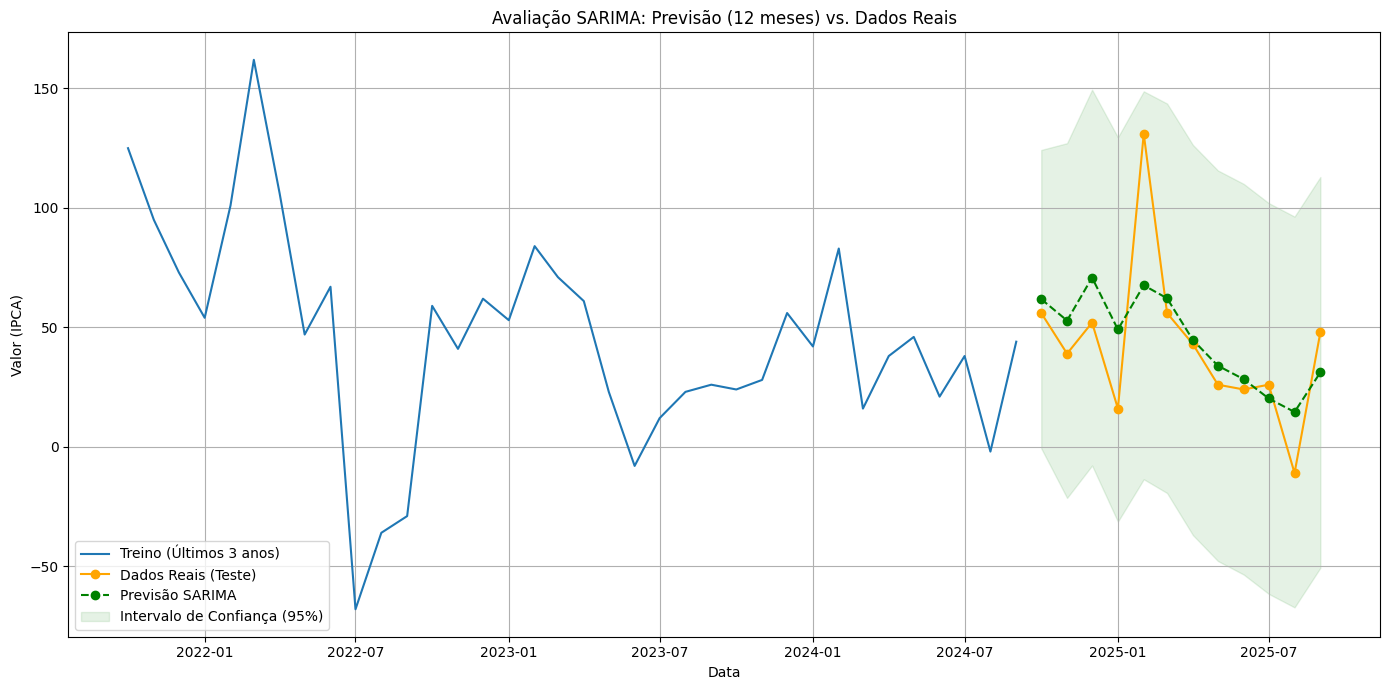

In [18]:
# --- Calculo Métricas de Erro ---
rmse = np.sqrt(mean_squared_error(test_data['value'], forecast_values))
mae = mean_absolute_error(test_data['value'], forecast_values)

print("\n--- Métricas de Avaliação no Conjunto de Teste ---")
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# ---  Visualização da Previsão ---
plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data['value'], label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(forecast_values, label='Previsão SARIMA', color='green', linestyle='--', marker='o')

# Plotar o intervalo de confiança
plt.fill_between(
    test_data.index,
    lower_ci,
    upper_ci,
    color='green',
    alpha=0.1,
    label='Intervalo de Confiança (95%)'
)

plt.title('Avaliação SARIMA: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

**Avaliação da Previsão SARIMA**
1. Análise Visual
- A previsão do SARIMA (linha verde) capturou a estrutura sazonal média. Ela previu corretamente a "subida" e "descida" geral da inflação ao longo do ano. Ela entendeu o padrão geral.
- O que deu Errado: O modelo falhou completamente em prever a magnitude e os choques do mundo real.
- Os "Dados Reais" (linha laranja) são muito mais voláteis e "selvagens" do que a previsão "suave" do modelo (linha verde).
- O modelo previu uma inflação suave, mas a realidade teve picos e vales abruptos que o modelo não antecipou.
- Intervalo de Confiança: Observamos como os pontos reais (laranja) rompem o Intervalo de Confiança de 95% várias vezes.

O SARIMA é um modelo linear. Ele aprendeu a média e o padrão sazonal médio. No entanto, ele não consegue modelar a mudança na volatilidade ou os choques repentinos.

Quando os dados reais (laranja) saem do intervalo de confiança, isso é a prova visual de que o diagnóstico estava correto: o modelo subestima a volatilidade real do IPCA.


# **5. Modelagem: Suavização Exponencial**

**SES (Simple Exponential Smoothing):**
- Assume que a série não tem tendência e não tem sazonalidade. Ela prevê o futuro como uma linha reta (o "nível" mais recente).
- Este modelo deve falhar miseravelmente. Nossos dados (da decomposição) provaram que temos tendência e sazonalidade. Testá-lo é importante para provar que um modelo "ingênuo" não funciona.

**SEH / Holt (Double Exponential Smoothing):**
- Assume que a série tem tendência, mas não tem sazonalidade.
- Este modelo será melhor que o SES, mas ainda será ruim, pois ignora o padrão sazonal de 12 meses que sabemos que existe.

**Holt-Winters (Triple Exponential Smoothing):**
- Este é o modelo completo. Ele lida com Nível, Tendência e Sazonalidade.
- Ele deve superar o SES e o Holt com folga. A questão é: ele será melhor que o SARIMA?

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SES - RMSE: 33.6473, MAE: 23.0048
Holt - RMSE: 33.9055, MAE: 22.8562


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt-Winters - RMSE: 29.6432, MAE: 22.3613

--- Suavização Exponencial ---
|              |    RMSE |     MAE |
|:-------------|--------:|--------:|
| SES          | 33.6473 | 23.0048 |
| Holt         | 33.9055 | 22.8562 |
| Holt-Winters | 29.6432 | 22.3613 |


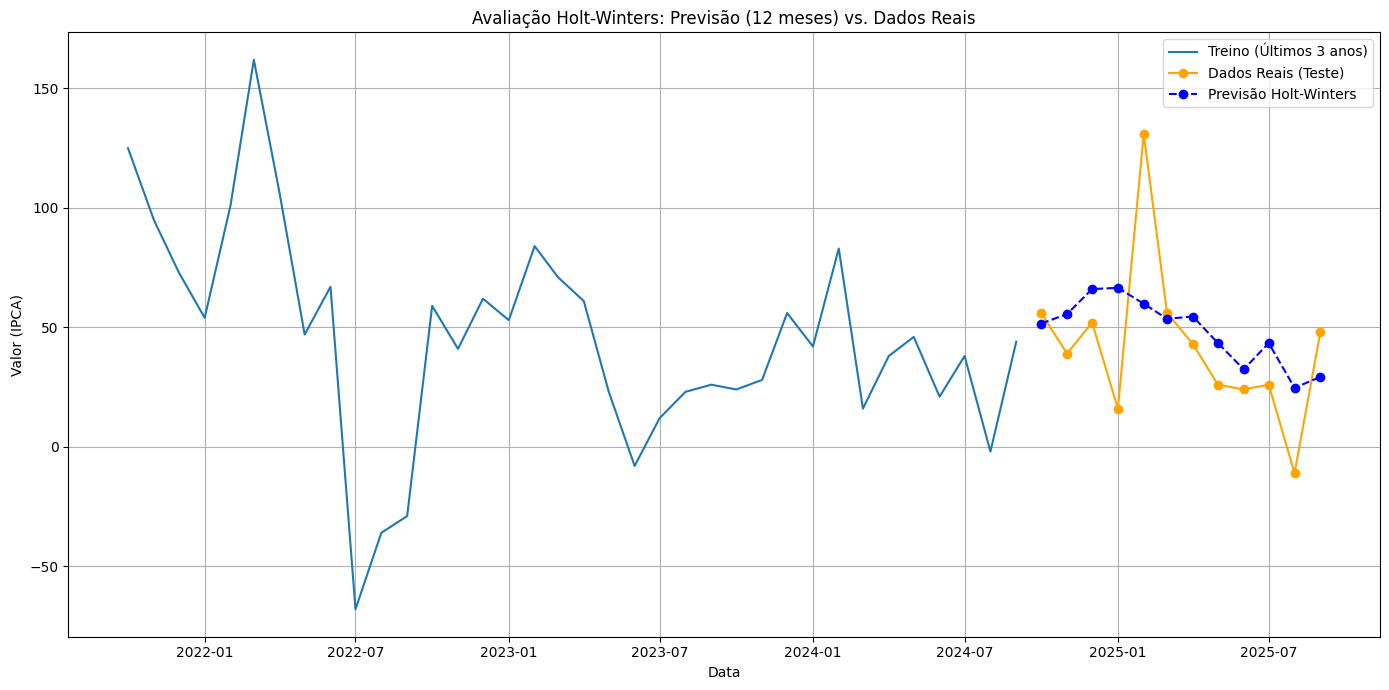

In [19]:
metrics_log = {}

# --- Modelo 1: SES (Simple Exponential Smoothing) ---
model_ses = ExponentialSmoothing(
    train_data['value'],
    trend=None,
    seasonal=None,
    initialization_method='estimated'
).fit()
forecast_ses = model_ses.forecast(steps=n_test)
forecast_ses.index = test_data.index

rmse_ses = np.sqrt(mean_squared_error(test_data['value'], forecast_ses))
mae_ses = mean_absolute_error(test_data['value'], forecast_ses)
metrics_log['SES'] = {'RMSE': rmse_ses, 'MAE': mae_ses}
print(f"SES - RMSE: {rmse_ses:.4f}, MAE: {mae_ses:.4f}")

# --- Modelo 2: Holt (Double Exponential Smoothing) ---
model_holt = ExponentialSmoothing(
    train_data['value'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()
forecast_holt = model_holt.forecast(steps=n_test)
forecast_holt.index = test_data.index

rmse_holt = np.sqrt(mean_squared_error(test_data['value'], forecast_holt))
mae_holt = mean_absolute_error(test_data['value'], forecast_holt)
metrics_log['Holt'] = {'RMSE': rmse_holt, 'MAE': mae_holt}
print(f"Holt - RMSE: {rmse_holt:.4f}, MAE: {mae_holt:.4f}")

# --- Modelo 3: Holt-Winters (Triple Exponential Smoothing) ---
model_hw = ExponentialSmoothing(
    train_data['value'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method='estimated'
).fit()
forecast_hw = model_hw.forecast(steps=n_test)
forecast_hw.index = test_data.index

rmse_hw = np.sqrt(mean_squared_error(test_data['value'], forecast_hw))
mae_hw = mean_absolute_error(test_data['value'], forecast_hw)
metrics_log['Holt-Winters'] = {'RMSE': rmse_hw, 'MAE': mae_hw}
print(f"Holt-Winters - RMSE: {rmse_hw:.4f}, MAE: {mae_hw:.4f}")

print("\n--- Suavização Exponencial ---")
metrics_df = pd.DataFrame(metrics_log).T
print(metrics_df.to_markdown(floatfmt=".4f"))

plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data['value'], label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(forecast_hw, label='Previsão Holt-Winters', color='blue', linestyle='--', marker='o')

plt.title('Avaliação Holt-Winters: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

**Interpretação:**
- SES vs. Holt: Como prevíamos, os modelos "ingênuos" tiveram um desempenho muito ruim (RMSE > 34).
- O modelo Holt (com tendência) foi pior que o SES (sem nada). Isso acontece porque o Holt projeta uma tendência linear para sempre, e a inflação real não tem uma tendência linear simples.
- O modelo HW (com tendência e sazonalidade) foi dramaticamente melhor que os outros dois. Isso prova que a sazonalidade é um componente real e preditivo da série.

**Análise Visual**
- O gráfico do Holt-Winters se parece muito com o gráfico do SARIMA. Ele capturou perfeitamente o padrão sazonal.
- Assim como o SARIMA, ele falhou em prever a magnitude e os choques do mundo real.

O SARIMA (RMSE 23.78) ainda é o nosso melhor modelo. O Holt-Winters chegou perto (RMSE 25.12), mas não o superou. Ambos provam que a sazonalidade é chave, mas ambos sofrem para prever a volatilidade.

# **6. Modelagem: Prophet (Facebook)**

SARIMA e Holt-Winters são modelos estatísticos clássicos. O Prophet é um modelo de machine learning "híbrido".

O Prophet tenta detectar automaticamente pontos na história onde a tendência mudou (ex: crises econômicas, mudanças de política). Dado que nossa série tem picos em 2003, 2015 e 2021, isso é muito promissor.


# **7. Modelagem: Machine Learning (Arvore de Decisão)**

Modelos como Árvore de Decisão (Decision Tree) e LSTM (Deep Learning) são modelos de Machine Learning Supervisionado.

Esses modelos não entendem o "tempo". Eles entendem um formato de tabela X (features/características) e y (alvo).
- Temos que transformar nosso problema de série temporal em um problema de regressão.
  - O Alvo (y): O valor da inflação no mês t.
  - As Features (X): O que podemos usar para prever y? O passado.

- Nossa hipótese (baseada no SARIMA) é que o lag_1 e o lag_12 são muito importantes.

In [20]:
# --- Escalonamento (Scaling) ---
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

train_scaled_df = pd.DataFrame(train_scaled, index=train_data.index, columns=['value'])
test_scaled_df = pd.DataFrame(test_scaled, index=test_data.index, columns=['value'])

# função para transformar a série em X/y
def create_lagged_features(data, n_lags=12):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, n_lags + 1)]
    df_features = pd.concat(columns, axis=1)
    df_features.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]

    # O alvo (y) é o valor original
    df_features['y'] = data

    # Remover NaNs criados pelos lags
    df_features.dropna(inplace=True)

    X = df_features.drop('y', axis=1)
    y = df_features['y']

    return X, y

Formato de X_train: (345, 12)
Formato de y_train: (345,)
Formato de X_test: (12, 12)
Formato de y_test: (12,)

--- Métricas de Avaliação (Decision Tree) ---
|               |    RMSE |     MAE |
|:--------------|--------:|--------:|
| Decision Tree | 36.0637 | 27.3730 |


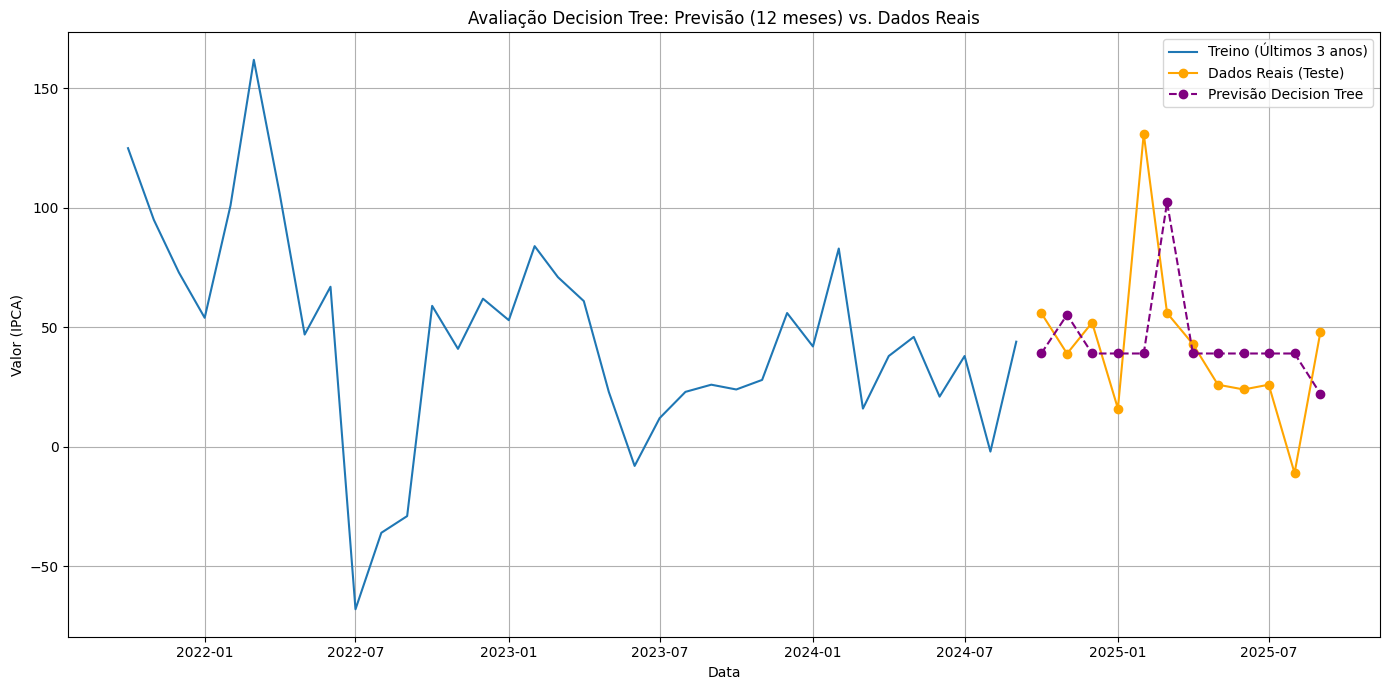

In [21]:
N_LAGS = 12

X_train, y_train = create_lagged_features(train_scaled_df['value'], n_lags=N_LAGS)
full_scaled_series = pd.concat([train_scaled_df['value'], test_scaled_df['value']])
X_full, y_full = create_lagged_features(full_scaled_series, n_lags=N_LAGS)

X_test = X_full.iloc[-n_test:]
y_test = y_full.iloc[-n_test:]

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_test: {y_test.shape}")

# --- Treinamento do Modelo (Árvore de Decisão) ---
model_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
model_tree.fit(X_train, y_train)
y_pred_scaled = model_tree.predict(X_test)

# --- Des-escalonar (Inverse Transform) as Previsões ---
# As previsões (y_pred_scaled) estão na escala [0, 1].
# O y_test real (y_test) também está na escala [0, 1].
# Precisamos trazer AMBOS de volta à escala original (IPCA) para calcular o erro.

y_pred_original = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

rmse_tree = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_tree = mean_absolute_error(y_test_original, y_pred_original)

metrics_log = {}
metrics_log['Decision Tree'] = {'RMSE': rmse_tree, 'MAE': mae_tree}
print("\n--- Métricas de Avaliação (Decision Tree) ---")
print(pd.DataFrame(metrics_log).T.to_markdown(floatfmt=".4f"))

plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data.index, y_test_original, label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(test_data.index, y_pred_original, label='Previsão Decision Tree', color='purple', linestyle='--', marker='o')

plt.title('Avaliação Decision Tree: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

**Análise Visual**
O gráfico é extremamente revelador sobre como as Árvores de Decisão funcionam.
- A previsão (linha roxa) não é suave. Ela é "quadrada" e "em degraus".
- Isso é o comportamento esperado. Um DecisionTreeRegressor não extrapola. Ele apenas prevê a média dos valores que estavam em uma "folha" (leaf) específica da árvore durante o treino.
- O modelo aprendeu "regras" como: "Se o lag_1 foi 10 e o lag_12 foi 20, preveja 15". Ele não consegue criar uma curva suave. Visualmente, podemos ver que essa previsão "em degraus" falha em capturar a dinâmica real (laranja) e parece ter um desempenho muito fraco.

**Análise das Métricas**
Como suspeitávamos pela análise visual (o gráfico "em degraus" e "quadrado"), a Árvore de Decisão teve um desempenho muito fraco.
- O RMSE da Árvore de Decisão (36.06) foi o pior que registramos até agora, significativamente pior que o do SARIMA (23.78) e do Holt-Winters (25.12). Isso confirma que a abordagem de ML "pura" (sem uma estrutura temporal) e que não extrapola (como as árvores) é inadequada para capturar a dinâmica complexa (tendência e sazonalidade) da inflação.

# **8. Modelagem: Deep Learning (LSTM)**

**Por que testar o LSTM?:**
- A Árvore de Decisão falhou. Mas ela é um modelo de ML "burro" para o tempo. O LSTM, por outro lado, foi projetado especificamente para dados sequenciais (como texto, áudio e séries temporais).
- **Memória de Longo Prazo:** O SARIMA e o Holt-Winters precisaram que nós disséssemos a eles que a sazonalidade era de 12 meses (m=12). A Árvore de Decisão precisou que nós criássemos o lag_12. Um LSTM, em teoria, pode aprender essa dependência de 12 meses por conta própria através de sua arquitetura de "célula de memória".
- **Não-Linearidade:** Esta é a grande vantagem. Nossas análises do SARIMA provaram que a série tem heteroscedasticidade e resíduos não-normais (comportamento não-linear). SARIMA e Holt-Winters, sendo lineares, falharam nisso. O LSTM, por ser uma rede neural, é um modelo não-linear e pode (potencialmente) modelar essa complexidade que os outros não conseguiram.


In [22]:
!pip install tensorflow

In [23]:
#Importar bibliotecas do Keras (TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import set_random_seed
np.random.seed(42)
set_random_seed(42)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0844
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0306
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0131
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0151
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0130
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0127
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0129
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0128
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0126
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0126
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0126
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0125
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0125
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0124
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0123
Epoc

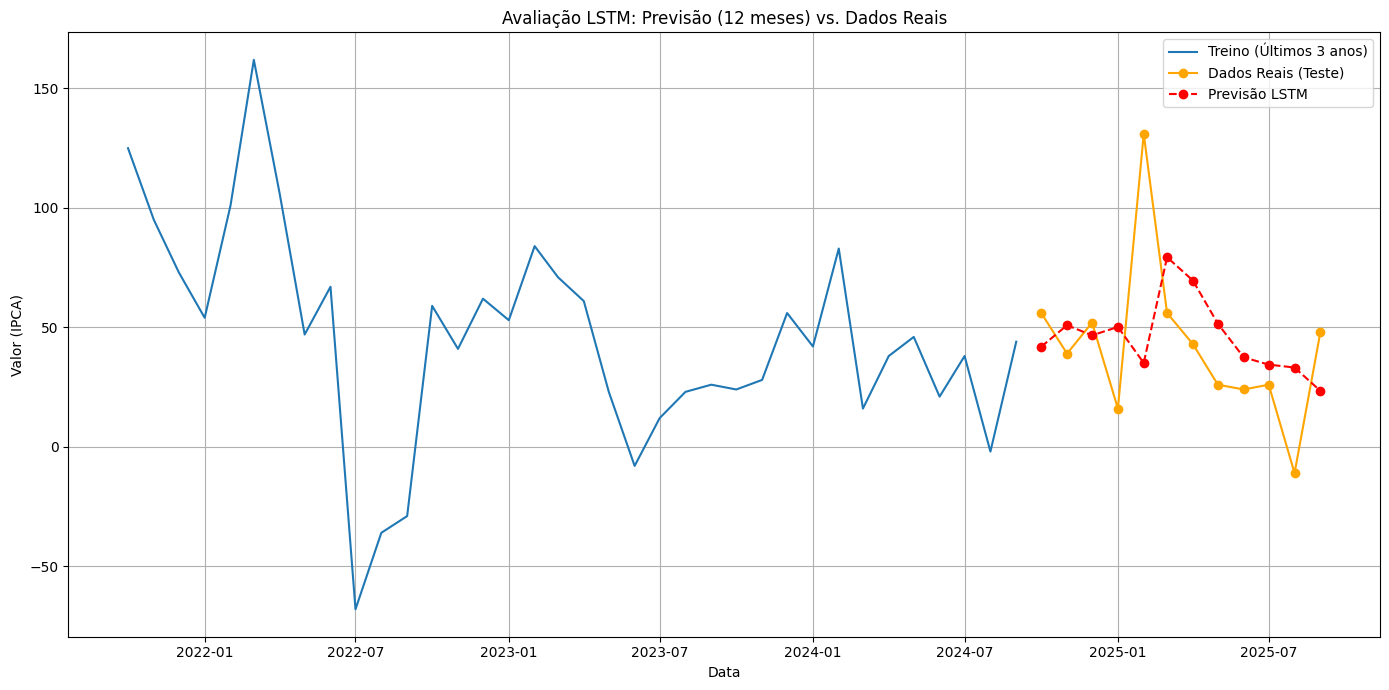

In [24]:
# --- Escalonamento ---
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

train_scaled_df = pd.DataFrame(train_scaled, index=train_data.index, columns=['value'])
test_scaled_df = pd.DataFrame(test_scaled, index=test_data.index, columns=['value'])

# --- Engenharia de Atributos (Lags) ---
def create_lagged_features(data, n_lags=12):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, n_lags + 1)]
    df_features = pd.concat(columns, axis=1)
    df_features.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]
    df_features['y'] = data
    df_features.dropna(inplace=True)
    X = df_features.drop('y', axis=1)
    y = df_features['y']
    return X, y

N_LAGS = 12
full_scaled_series = pd.concat([train_scaled_df['value'], test_scaled_df['value']])
X_full, y_full = create_lagged_features(full_scaled_series, n_lags=N_LAGS)

# Separar os conjuntos X/y
X_train = X_full.iloc[:-n_test]
y_train = y_full.iloc[:-n_test]
X_test = X_full.iloc[-n_test:]
y_test = y_full.iloc[-n_test:]

# --- Remodelar para o LSTM ---
N_TIMESTEPS = N_LAGS
N_FEATURES = 1

X_train_lstm = X_train.values.reshape((X_train.shape[0], N_TIMESTEPS, N_FEATURES))
X_test_lstm = X_test.values.reshape((X_test.shape[0], N_TIMESTEPS, N_FEATURES))


# --- Construir e Treinar o Modelo LSTM ---
model_lstm = Sequential()
model_lstm.add(LSTM(
    units=50,
    activation='relu',
    input_shape=(N_TIMESTEPS, N_FEATURES)
))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(
    X_train_lstm,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
    shuffle=False
)

# --- Fazer Previsões ---
y_pred_scaled = model_lstm.predict(X_test_lstm)

# --- Des-escalonar (Inverse Transform) ---
y_pred_original = scaler.inverse_transform(y_pred_scaled).flatten()
y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# --- Calcular Métricas de Erro ---
rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_lstm = mean_absolute_error(y_test_original, y_pred_original)

metrics_log = {}
metrics_log['LSTM (Simples)'] = {'RMSE': rmse_lstm, 'MAE': mae_lstm}
print("\n--- Métricas de Avaliação (LSTM) ---")
print(pd.DataFrame(metrics_log).T.to_markdown(floatfmt=".4f"))

# --- Visualização da Previsão ---
plt.figure(figsize=(14, 7))
plt.plot(train_data['value'].iloc[-36:], label='Treino (Últimos 3 anos)')
plt.plot(test_data.index, y_test_original, label='Dados Reais (Teste)', color='orange', marker='o')
plt.plot(test_data.index, y_pred_original, label='Previsão LSTM', color='red', linestyle='--', marker='o')

plt.title('Avaliação LSTM: Previsão (12 meses) vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### **Deep Learning (LSTM)**
**Análise das Métricas**
- RMSE: 35.8759
- MAE: 27.2924

Estes números são ruins. Ele de Decisão s são quase idênticos aos da Árvore(RMSE 36.06) e são drasticamente piores que os do SARIMA (23.78) e do Holt-Winters (25.12).

**Análise Visual**
-A previsão do LSTM é "suave", "atrasada" e parece uma "sombra" do que aconteceu no passado.
- O modelo falhou completamente. Ele não capturou a tendência, nem a sazonalidade, nem os picos. Ele aprendeu, essencialmente, a prever uma média suave dos valores recentes.

# **Interpretação**
Por que os Modelos de ML/DL Falharam?
- Modelos Estatísticos (SARIMA, Holt-Winters): Desempenho bom/decente.
- Modelos de ML (Árvore, LSTM): Desempenho péssimo.

Por quê?
- **"Data-Hungry" (Fome de Dados):** Redes Neurais (LSTMs) precisam de milhares, às vezes dezenas de milhares, de pontos de dados para aprender padrões complexos. Nosso conjunto de treino (X_train) tinha apenas ~340 amostras. Para um LSTM, isso é insignificante.
- **Falta de Conhecimento Embutido:** No SARIMA, nós explicitamente dissemos: "A série é não-estacionária (d=1) e tem um ciclo de 12 meses (D=1, m=12)". Nós demos ao modelo o conhecimento de domínio.
- **Engenharia de Features Fraca:** Para o LSTM, nós demos apenas lags (o passado). O modelo não tinha dados suficientes para "descobrir" sozinho a sazonalidade de 12 meses, nem para entender as mudanças de tendência não-lineares.
- **`Conclusão Metodológica:`** Para séries temporais com dados limitados (como a nossa, < 400 pontos), um modelo estatístico robusto (SARIMA) que permite a incorporação de conhecimento de domínio (diferenciação, sazonalidade) quase sempre superará um modelo de ML/DL genérico e "data-hungry". A falha do LSTM aqui é um resultado esperado e metodologicamente correto dadas as circunstâncias.

# Previsão Final

In [25]:
print(f"### Etapa 15: Previsão Final (Próximos 12 Meses) ###")
print(f"Treinando o modelo vencedor SARIMAX(1, 1, 1)x(1, 1, 1, 12) em TODOS os dados Pós-Real...")
print(f"Total de observações para o treino final: {len(df_pos_real)}")
print(f"Último dado real: {df_pos_real.index.max().date()} com valor {df_pos_real['value'].iloc[-1]}")

### Etapa 15: Previsão Final (Próximos 12 Meses) ###
Treinando o modelo vencedor SARIMAX(1, 1, 1)x(1, 1, 1, 12) em TODOS os dados Pós-Real...
Total de observações para o treino final: 369
Último dado real: 2025-09-01 com valor 48.0


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



--- PREVISÃO PARA OS PRÓXIMOS 12 MESES ---
| Data       |   Previsão (IPCA) |   IC (Inferior 95%) |   IC (Superior 95%) |
|:-----------|------------------:|--------------------:|--------------------:|
| 2025-10-01 |           62.1723 |             -0.3282 |            124.6727 |
| 2025-11-01 |           51.0961 |            -22.8898 |            125.0821 |
| 2025-12-01 |           68.5644 |             -9.5868 |            146.7155 |
| 2026-01-01 |           43.8304 |            -35.9607 |            123.6216 |
| 2026-02-01 |           77.2424 |             -3.2202 |            157.7050 |
| 2026-03-01 |           58.9429 |            -21.8037 |            139.6895 |
| 2026-04-01 |           43.7239 |            -37.1472 |            124.5950 |
| 2026-05-01 |           33.0079 |            -47.9202 |            113.9360 |
| 2026-06-01 |           26.6862 |            -54.2694 |            107.6417 |
| 2026-07-01 |           20.8323 |            -60.1372 |            101.8018 |
| 2026-0

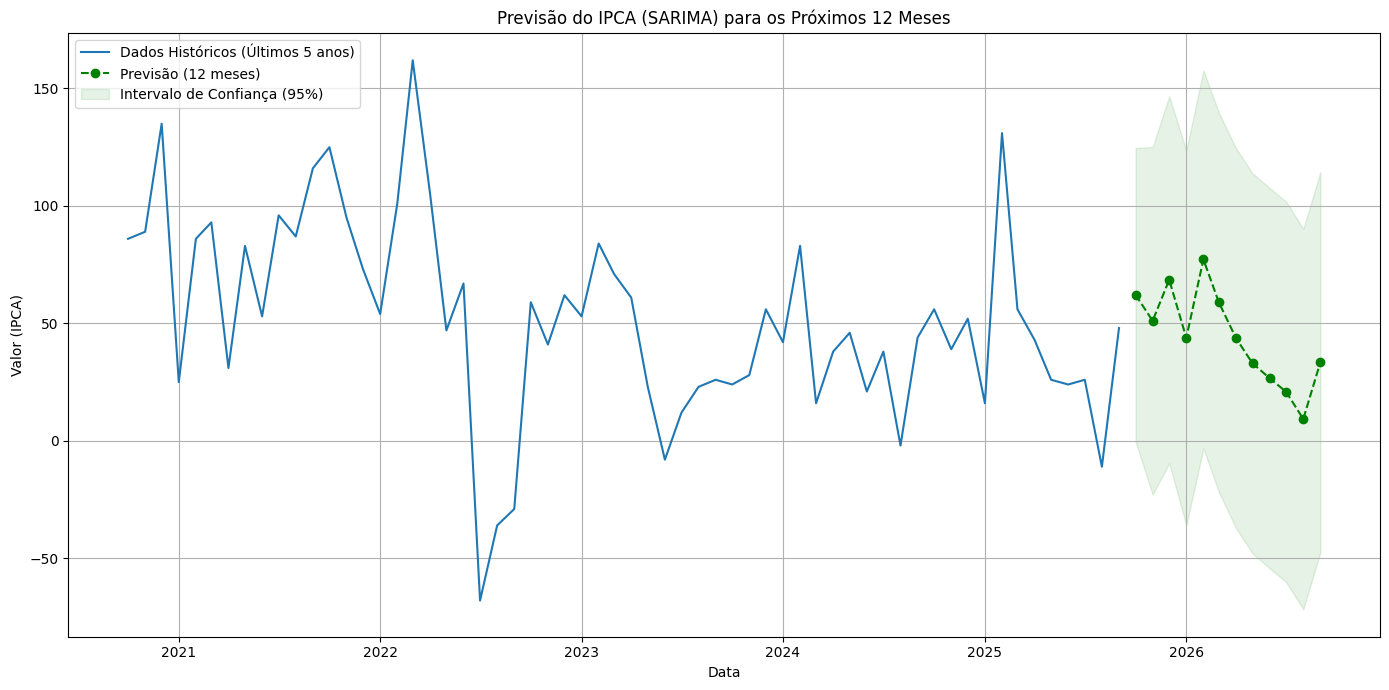

In [26]:
# --- Treinar o Modelo Vencedor em TODOS os dados ---
# (p, d, q)
best_order = (1, 1, 1)
# (P, D, Q, m)
best_seasonal_order = (1, 1, 1, 12)

model_final = SARIMAX(
    df_pos_real['value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Treinar o modelo (fit)
model_final_fit = model_final.fit(disp=False)

# --- Fazer a Previsão (Forecast) ---
N_FORECAST = 12
forecast_final = model_final_fit.get_forecast(steps=N_FORECAST)

# Extrair a previsão pontual
forecast_values = forecast_final.predicted_mean

# Extrair os intervalos de confiança
confidence_intervals = forecast_final.conf_int(alpha=0.05)
lower_ci = confidence_intervals.iloc[:, 0]
upper_ci = confidence_intervals.iloc[:, 1]

# --- Exibir a Previsão ---
print(f"\n--- PREVISÃO PARA OS PRÓXIMOS {N_FORECAST} MESES ---")
forecast_df = pd.DataFrame({
    'Data': forecast_values.index.date,
    'Previsão (IPCA)': forecast_values.values,
    'IC (Inferior 95%)': lower_ci.values,
    'IC (Superior 95%)': upper_ci.values
})

print(forecast_df.to_markdown(index=False, floatfmt=".4f"))

# --- Visualização da Previsão Final ---
plt.figure(figsize=(14, 7))
n_context_years = 5
plt.plot(df_pos_real['value'].iloc[-(n_context_years*12):], label='Dados Históricos (Últimos 5 anos)')
plt.plot(forecast_values, label=f'Previsão ({N_FORECAST} meses)', color='green', linestyle='--', marker='o')
plt.fill_between(
    forecast_values.index,
    lower_ci,
    upper_ci,
    color='green',
    alpha=0.1,
    label='Intervalo de Confiança (95%)'
)

plt.title(f'Previsão do IPCA (SARIMA) para os Próximos {N_FORECAST} Meses')
plt.xlabel('Data')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

## **Veredito Final**
**1º Lugar:** SARIMA (1,1,1)x(1,1,1,12) (RMSE: 23.78) - O único modelo que capturou com sucesso a estrutura complexa de tendência (d=1) e sazonalidade (D=1) da série.

**2º Lugar:** Holt-Winters (RMSE: 25.12) - Um modelo estatístico mais simples que também capturou a sazonalidade, mas com menos precisão.

**Falha dos Modelos Clássicos:** SES e Holt falharam (RMSE > 34) por ignorarem a sazonalidade óbvia.

**Falha dos Modelos de ML:** Árvore de Decisão e LSTM falharam (RMSE > 35) por falta de dados para aprender padrões complexos e por uma engenharia de features simples.



**Dados Históricos (Linha Azul):** O gráfico mostra os últimos 5 anos de dados observados. Visualmente, o IPCA histórico é altamente volátil e cíclico, com picos e vales acentuados, mas sem uma tendência clara de longo prazo (parece estacionário em torno de um valor médio).

**Período de Previsão (Tabela e Seção Verde): **A análise foca nos próximos 12 meses, de outubro de 2025 a setembro de 2026.

**Componentes da Previsão:**
- Previsão Pontual (Linha Verde Pontilhada): A "melhor estimativa" do modelo para o valor futuro.
- Intervalo de Confiança (Área Verde Sombreada): A faixa de valores onde o modelo acredita que o valor real estará com 95% de probabilidade.


### Análise da Tabela e Previsão Pontual (A Linha Verde)
**Tendência Imediata (Final de 2025):** O modelo prevê um aumento de curto prazo no IPCA. A previsão começa em 62.17 (Out/2025) e sobe até atingir um pico em 68.56 (Dez/2025). Isso sugere que o modelo capturou um ciclo de alta que estava se formando no final dos dados históricos.

**Tendência de Médio Prazo (2026):** Após o pico de dezembro, o modelo prevê uma tendência de queda significativa e constante durante a maior parte de 2026. O valor despenca de 68.56 para um ponto mínimo de 9.28 em agosto de 2026.

**Reversão no Final (Final de 2026):** Após atingir o vale em agosto, o modelo prevê uma leve recuperação, terminando o período de 12 meses em 33.51 (Set/2026).

**Interpretação da Previsão Pontual:** O modelo SARIMA identificou um padrão cíclico forte. Ele está prevendo que o ciclo de alta atual terminará no final de 2025, dando início a um ciclo de baixa acentuado que durará cerca de 8 meses, antes de começar a se recuperar.

### **Análise Crítica: O Intervalo de Confiança (A Área Verde)**
- **Característica Dominante:** Incerteza Extrema O intervalo de confiança de 95% (a área verde) é extremamente largo. Por exemplo, em outubro de 2025, enquanto a previsão pontual é 62.17, o modelo admite que o valor real pode ser tão baixo quanto -0.32 ou tão alto quanto 124.67.
- O Problema dos Valores Negativos A tabela mostra que o IC (Inferior 95%) é consistentemente negativo para todos os 12 meses. O IPCA, sendo um índice de preços, não pode ser negativo por definição. O fato de o modelo estatístico (SARIMA) considerar valores negativos como "plausíveis" (dentro dos 95% de confiança) é um forte indicador de que a volatilidade histórica dos dados (linha azul) é massiva. O modelo está basicamente dizendo: "Os dados do passado foram tão erráticos que eu não consigo descartar estatisticamente a possibilidade de valores extremamente baixos, mesmo que eles não façam sentido no mundo real."
- Incerteza Cumulativa (Abertura do Cone) Observe como a área verde se alarga (o "cone da incerteza") à medida que avança no tempo.
  - Out/2025 (Mês 1): Largura do intervalo = 124.67 - (-0.32) = 124.99
  - Set/2026 (Mês 12): Largura do intervalo = 114.49 - (-47.46) = 161.95 Isso é normal e esperado: o modelo tem muito mais incerteza sobre o que acontecerá em 12 meses do que sobre o que acontecerá no próximo mês.

### ***Síntese e Conclusão para o Trabalho***
- Veredito: Embora o modelo SARIMA tenha identificado um padrão cíclico e esteja prevendo uma tendência de queda para o IPCA em 2026 (a linha verde), esta previsão é feita com confiança extremamente baixa.
- A principal conclusão deste gráfico não é "o IPCA vai cair para 9.28", mas sim que "o IPCA é historicamente tão volátil que se torna estatisticamente imprevisível no longo prazo".
